# Imports

In [91]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.inspection import permutation_importance
import ta
from xgboost import XGBClassifier

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv('Data/Training/pair_features_updated_300_20.csv')
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading
0,2015-01-02,MMM,119.196,AKAM,63.250,165.080,63.900,162.730,62.520,2116400.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.709,False
1,2015-01-05,MMM,116.507,AKAM,61.940,163.640,62.340,160.080,60.760,3692900.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.547,False
2,2015-01-06,MMM,115.265,AKAM,60.670,161.370,62.190,157.740,60.100,3532000.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.122,False
3,2015-01-07,MMM,116.101,AKAM,60.160,160.280,60.960,158.940,59.930,3081300.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.883,False
4,2015-01-08,MMM,118.883,AKAM,61.570,163.690,61.860,160.520,60.600,3142900.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.170,False


In [3]:
total_days = df.Date.nunique()
total_days

1257

In [4]:
print(df.shape)
df.isna().sum()

(1539825, 33)


Date                              0
Ticker_P1                         0
Close_P1                          0
Ticker_P2                         0
Close_P2                          0
High_P1                           0
High_P2                           0
Low_P1                            0
Low_P2                            0
Volume_P1                         0
Volume_P2                         0
abs_spread                        0
same_sector_flag                  0
same_sub_industry_flag            0
abs_spread_mean              366275
abs_spread_std               366275
abs_spread_mean_l20           23275
abs_spread_std_l20            23275
spread_normed                366275
abs_spread_normed_max        732550
abs_spread_normed_90th       732550
abs_spread_normed_75th       732550
abs_spread_normed_median     732550
abs_spread_normed_l7_avg     373625
abs_spread_normed_l14_avg    382200
cos_sim                      366275
corr_coef                    366275
pnls                        

In [5]:
df.Date.nunique()

1257

In [6]:
df.abs_spread_normed_max.dropna().describe()

count   807275.000
mean         3.091
std          0.662
min          1.002
25%          2.642
50%          3.015
75%          3.457
max          7.195
Name: abs_spread_normed_max, dtype: float64

In [7]:
df = df.sort_values('Date')

In [8]:
print(df.Date.min(),df.Date.max())

2015-01-02 2019-12-30


# Feature Engineering

In [9]:
# TODO:
# 1. Add group based features
# 2. Stock2Vec based features
# 3. Add Technical Indicators
# 4. target is a sum of 2 directions with magnitudes (how much it goes up/down per leg)
# 5. rolling features
# 6. probability of classification model
# 7. historical pnl and num_entries, drop leaky num_entries
# 8. differencing features.

In [10]:
# 3 dimensions from a product perspective: ticker1, ticker2, and pair
# 2 dimensions from a time perspective: short term vs long term
# 2 factors of PnL: Volatility, and Reversion to mean

# short term ticker 1 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term ticker 2 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term pair level volatility: rolling mean, sector rolling mean, rolling std, sector rolling std, 
#                                   differences of ticker level features

# long term ticker 1 volatility: beta,
# long term ticker 2 volatility: beta,
# long term pair level volatility: most recent PNL (which is from 120 days ago), average historical PNL
#                                  most recent number of entries, historical average vnumber of entries, 
#                                  diff of beta

# short term ticker 1 reversion to mean: technical indicators
# short term ticker 2 reversion to mean: technical indicators
# short term pair level reversion to mean: technical indicators

# long term ticker 1 reversion to mean: technical indicators
# long term ticker 2 reversion to mean: technical indicators
# long term pair level reversion to mean: technical indicators

## Technical Indicators

In [11]:
class feature_engineering(object):
    def __init__(self):
        super(feature_engineering, self).__init__()

    def generate_technical_indicator(self, data_df): 
        '''
        Function to generate additional technical indicators for the stock

        Uses the "statsmodels.tsa.stattools" (as "ts") package to apply 
        the equations specified in the "Technical Indicators" markdown section 
        to stock closing data.
        
        Input:
        data_df-- Dataframe containing stock finacials data
        
        Output:
        Stock finacials data with added Dataframe of feature obtained from feature engineering
        ''' 
        # 1. Momentum Indicators
        # Relative Strength Index
        df = data_df
        df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
        # Kaufman’s Adaptive Moving Average (KAMA)
        df['kama'] = ta.momentum.kama(df['Close'],window=14)

        # 2. Volume Indicators
        # Accumulation/Distribution Index (ADI)
        df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

        # Volume-price trend (VPT)
        df['vpt'] = ta.volume.volume_price_trend(df['Close'], df['Volume'])

        # 3. Volatility Indicators
        # Average True Range (ATR)
        df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

        # Bollinger Bands (BB) N-period simple moving average (MA)
        df['bb_ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)

        # 4. Trend Indicators
        # Average Directional Movement Index (ADX)
        df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

        # Exponential Moving Average
        df['ema'] = ta.trend.ema_indicator(df['Close'], window=14)

        # Moving Average Convergence Divergence (MACD)
        df['macd'] = ta.trend.macd(df['Close'], window_fast=14, window_slow=30)

        # 5. Other Indicators
        # Daily Log Return (DLR)
        df['dlr'] = ta.others.daily_log_return(df['Close'])

        # Daily Returns
        df['daily_returns'] = df['Close'].pct_change()

        # Moving Averages
        averages = [50,200]
        for avg in averages:
            col_name = str(avg) +' Days Average'
            df[col_name] = df['Close'].rolling(window = avg, center = False).mean()

        return df

### Load SPY

In [12]:
spy_df = pd.read_csv('Data/Training/1999-12-01-2023-12-31_SPY.csv')
spy_df = spy_df[['Date','Adj Close']]
spy_df.columns = ['Date','SPY_Close']
df = pd.merge(df,spy_df,on='Date',how='left')

### Beta

In [13]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [14]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

98

In [15]:
fe_obj = feature_engineering()


### Single Ticker Features

In [16]:
df.columns

Index(['Date', 'Ticker_P1', 'Close_P1', 'Ticker_P2', 'Close_P2', 'High_P1',
       'High_P2', 'Low_P1', 'Low_P2', 'Volume_P1', 'Volume_P2', 'abs_spread',
       'same_sector_flag', 'same_sub_industry_flag', 'abs_spread_mean',
       'abs_spread_std', 'abs_spread_mean_l20', 'abs_spread_std_l20',
       'spread_normed', 'abs_spread_normed_max', 'abs_spread_normed_90th',
       'abs_spread_normed_75th', 'abs_spread_normed_median',
       'abs_spread_normed_l7_avg', 'abs_spread_normed_l14_avg', 'cos_sim',
       'corr_coef', 'pnls', 'num_entries', 'days_till_first_entry',
       'both_legs_profited', 'SPY_return', 'successful_pair_trading',
       'SPY_Close'],
      dtype='object')

In [17]:
all_tickers_df_list = []
for t in tqdm(all_tickers):
    single_ticker_df = (df[df['Ticker_P1']==t] if t in df['Ticker_P1'].unique() else df[df['Ticker_P2']==t])
    single_ticker_df = single_ticker_df.sort_values('Date')
    single_ticker_df = single_ticker_df[['Date','Ticker_P1','Close_P1','High_P1','Low_P1','Volume_P1','SPY_Close']] if t in df['Ticker_P1'].unique() else\
                       single_ticker_df[['Date','Ticker_P2','Close_P2','High_P2','Low_P2','Volume_P2','SPY_Close']]
    single_ticker_df.columns = ['Date','Ticker','Close','High','Low','Volume','SPY_Close']
    single_ticker_df = single_ticker_df.drop_duplicates()

    single_ticker_df['rolling_beta'] = single_ticker_df['Close'].rolling(300).progress_apply(compute_beta, \
                                        args=(single_ticker_df,'Close','SPY_Close'))

    single_ticker_df_with_technical_indicators = fe_obj.generate_technical_indicator(single_ticker_df)

    all_tickers_df_list.append(single_ticker_df_with_technical_indicators)


  0%|          | 0/98 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [18]:
all_tickers_df = pd.concat(all_tickers_df_list,axis=0,ignore_index=True).reset_index(drop=True)
all_tickers_df.shape

(123186, 21)

In [19]:
df = df.reset_index(drop=True)

In [20]:
print(df.shape)
all_tickers_df_P1_suffix = all_tickers_df.copy()
all_tickers_df_P1_suffix.columns = ['Date','Ticker']+[c+'_P1' for c in all_tickers_df.columns if c not in ['Date','Ticker']]
all_tickers_df_P2_suffix = all_tickers_df.copy()
all_tickers_df_P2_suffix.columns = ['Date','Ticker']+[c+'_P2' for c in all_tickers_df.columns if c not in ['Date','Ticker']]

df = pd.merge(df,all_tickers_df_P1_suffix,left_on=['Date','Ticker_P1'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P1']).drop_duplicates()
print(df.shape)
df = pd.merge(df,all_tickers_df_P2_suffix,left_on=['Date','Ticker_P2'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P2']).drop_duplicates()
print(df.shape)
df = df.loc[:,~df.columns.duplicated()]
print(df.shape)

(1539825, 34)
(1539825, 54)
(1539825, 74)
(1539825, 73)


In [21]:
del all_tickers_df_P1_suffix, all_tickers_df_P2_suffix
gc.collect()

153

### Future Spreads

In [22]:
df = df.drop('Ticker',axis=1)

In [23]:
for i in range(17,20):
    df['FUTURE_abs_spread_longterm'+str(i)] = df.groupby(['Ticker_P1','Ticker_P2'])['abs_spread'].shift(-1*i)

for i in range(1,3):
    df['FUTURE_abs_spread_shortterm'+str(i)] = df.groupby(['Ticker_P1','Ticker_P2'])['abs_spread'].shift(-1*i)
    
df['FUTURE_abs_spread_avg_longterm'] = df[[c for c in df.columns if 'FUTURE_abs_spread_longterm' in c]].mean(axis=1)
df['FUTURE_abs_spread_avg_shortterm'] = df[[c for c in df.columns if 'FUTURE_abs_spread_shortterm' in c]].mean(axis=1)

### Prev Values

In [24]:
df = df.sort_values('Date')

In [25]:
df['PREV_num_entries'] = df.groupby(['Ticker_P1','Ticker_P2']).num_entries.shift(21)
df['PREV_pnls'] = df.groupby(['Ticker_P1','Ticker_P2']).pnls.shift(21)

# Trim head and tail days

In [26]:
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).head(301).index,axis=0)
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).tail(21).index,axis=0)
print(df.shape)

(1539825, 81)
(1171100, 81)
(1145375, 81)


## Diff Values

In [27]:
for c in ['Close', 'High', 'Low', 'Volume', 'rolling_beta', 'rsi', 'kama',
       'adi', 'vpt', 'atr', 'bb_ma', 'adx', 'ema', 'macd', 'dlr',
       'daily_returns', '50 Days Average', '200 Days Average']:
# ,
#        'sector_rolling_beta_mean', 'sector_rolling_beta_std',
#        'sector_daily_return_mean', 'sector_daily_return_std']:
    df['DIFF_'+c] = df[c+'_P1'] - df[c+'_P2']

In [28]:
df['DIFF_abs_spread_mean_l20_500'] = df['abs_spread_mean_l20'] - df['abs_spread_mean']

In [29]:
df.isna().sum().sort_values(ascending=False).head(20)/df.shape[0]

days_till_first_entry          0.408
abs_spread_normed_median       0.318
abs_spread_normed_max          0.318
abs_spread_normed_90th         0.318
abs_spread_normed_75th         0.318
PREV_num_entries               0.021
PREV_pnls                      0.021
abs_spread_normed_l14_avg      0.012
abs_spread_normed_l7_avg       0.004
DIFF_adi                       0.000
adi_P2                         0.000
adi_P1                         0.000
daily_returns_P2               0.000
200 Days Average_P2            0.000
FUTURE_abs_spread_longterm17   0.000
FUTURE_abs_spread_longterm18   0.000
50 Days Average_P2             0.000
macd_P2                        0.000
dlr_P2                         0.000
FUTURE_abs_spread_shortterm1   0.000
dtype: float64

In [30]:
# stop

# Pre_processing

## Create additional labels

In [31]:
# Correct the labels
df.both_legs_profited = df.both_legs_profited=='True'

df['direction_longterm_entry'] = np.where((df['FUTURE_abs_spread_avg_longterm'] - (df['abs_spread_mean']+1.5*df['abs_spread_std']))>0,1,0)
df['direction_longterm_exit'] = np.where((df['FUTURE_abs_spread_avg_longterm'] - (df['abs_spread_mean']+0.1*df['abs_spread_std']))<0,1,0)

df['direction_shortterm_entry'] = np.where((df['FUTURE_abs_spread_avg_shortterm'] - (df['abs_spread_mean']+1.5*df['abs_spread_std']))>0,1,0)
df['direction_shortterm_exit'] = np.where((df['FUTURE_abs_spread_avg_shortterm'] - (df['abs_spread_mean']+0.1*df['abs_spread_std']))<0,1,0)

## Removing NAs after determining features to keep

In [32]:
features = ['Close_P1', 'Close_P2', 'High_P1',
       'High_P2', 'Low_P1', 'Low_P2', 'Volume_P1', 'Volume_P2', 'abs_spread',
       'same_sector_flag', 'same_sub_industry_flag', 'abs_spread_mean',
       'abs_spread_std', 'abs_spread_mean_l20', 'abs_spread_std_l20',
       'spread_normed', 'abs_spread_normed_max', 'abs_spread_normed_90th',
       'abs_spread_normed_75th', 'abs_spread_normed_median',
       'abs_spread_normed_l7_avg', 'abs_spread_normed_l14_avg', 'cos_sim',
       # 'corr_coef_l5', 'corr_coef_l10', 'corr_coef_l15', 'corr_coef_l20',
       # 'corr_coef_l40', 'corr_coef_l60', 
       'corr_coef',
       'rolling_beta_P1',
       'rsi_P1', 'kama_P1', 'adi_P1', 'vpt_P1', 'atr_P1', 'bb_ma_P1', 'adx_P1',
       'ema_P1', 'macd_P1', 'dlr_P1', 'daily_returns_P1', '50 Days Average_P1',
       '200 Days Average_P1', 'rolling_beta_P2', 'rsi_P2', 'kama_P2',
       'adi_P2', 'vpt_P2', 'atr_P2', 'bb_ma_P2', 'adx_P2', 'ema_P2', 'macd_P2',
       'dlr_P2', 'daily_returns_P2', '50 Days Average_P2',
       '200 Days Average_P2', 'PREV_num_entries', 'PREV_pnls', 'DIFF_Close',
       'DIFF_High', 'DIFF_Low', 'DIFF_Volume', 'DIFF_rolling_beta', 'DIFF_rsi',
       'DIFF_kama', 'DIFF_adi', 'DIFF_vpt', 'DIFF_atr', 'DIFF_bb_ma',
       'DIFF_adx', 'DIFF_ema', 'DIFF_macd', 'DIFF_dlr', 'DIFF_daily_returns',
       'DIFF_50 Days Average', 'DIFF_200 Days Average',
       'DIFF_abs_spread_mean_l20_500']

labels = ['direction_shortterm_entry', 'direction_longterm_exit']

In [33]:
print(df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=features+labels)
print(df.shape)

(1145375, 104)
(750192, 104)


# Modeling - short term entry

## Train test split

In [34]:
X = df[features]
y = df['direction_shortterm_entry']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [35]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())
print(df.loc[X_train.index].Date.min(),df.loc[X_train.index].Date.max())
print(df.loc[X_test.index].Date.min(),df.loc[X_test.index].Date.max())

2019-05-30 2019-08-29
2017-05-18 2019-05-30
2019-08-29 2019-11-27


In [36]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(600153, 73)
(75019, 73)
(75020, 73)


In [37]:
y_train.value_counts()

direction_shortterm_entry
0    433629
1    166524
Name: count, dtype: int64

In [38]:
y_val.value_counts()

direction_shortterm_entry
0    54481
1    20538
Name: count, dtype: int64

In [39]:
y_test.value_counts()

direction_shortterm_entry
0    51618
1    23402
Name: count, dtype: int64

In [40]:
y_test.mean()

0.31194348173820313

In [41]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

## XGBoost Classification

In [42]:
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

xgb_st_entry = XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.3, objective='binary:logistic')
xgb_st_entry.fit(scaled_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
# Plot feature importances
importances = xgb_st_entry.feature_importances_
feature_imp_tb_xgb = pd.DataFrame()
feature_imp_tb_xgb['features'] = features
feature_imp_tb_xgb['importances'] = importances
feature_imp_tb_xgb.sort_values('importances', ascending=False).head(10)

,features,importances
15,spread_normed,0.620
36,50 Days Average_P1,0.009
37,200 Days Average_P1,0.008
50,50 Days Average_P2,0.008
51,200 Days Average_P2,0.008
40,kama_P2,0.007
46,ema_P2,0.007
2,High_P1,0.007
4,Low_P1,0.007
0,Close_P1,0.007


### Traditional Evaluation

In [44]:
# Predict the labels for the test set
y_pred = xgb_st_entry.predict(scaled_X_test)
y_pred_proba = [x[1] for x in xgb_st_entry.predict_proba(scaled_X_test)]

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     51618
           1       0.87      0.95      0.90     23402

    accuracy                           0.94     75020
   macro avg       0.92      0.94      0.93     75020
weighted avg       0.94      0.94      0.94     75020



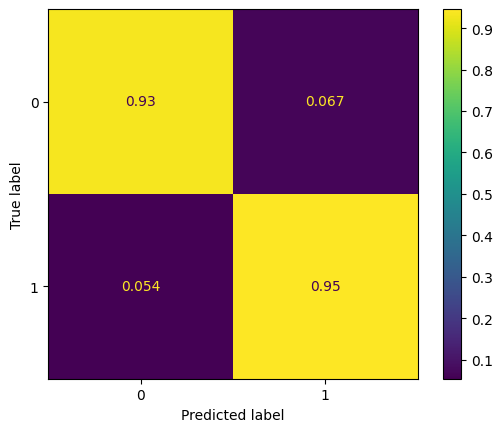

In [45]:
# Calculate precision, recall, and F1 scoreb
report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Modeling - long term exit

## Train test split

In [57]:
X = df[features]
y = df['direction_longterm_exit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [58]:
y_test.mean()

0.3120234604105572

In [59]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

## XGBoost Classification

In [49]:
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

xgb_lt_exit = XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.3, objective='binary:logistic')
xgb_lt_exit.fit(scaled_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
# Plot feature importances
importances = xgb_lt_exit.feature_importances_
feature_imp_tb_xgb = pd.DataFrame()
feature_imp_tb_xgb['features'] = features
feature_imp_tb_xgb['importances'] = importances
feature_imp_tb_xgb.sort_values('importances', ascending=False).head(10)

,features,importances
15,spread_normed,0.412
26,kama_P1,0.019
36,50 Days Average_P1,0.018
37,200 Days Average_P1,0.016
27,adi_P1,0.015
51,200 Days Average_P2,0.014
52,PREV_num_entries,0.013
41,adi_P2,0.013
32,ema_P1,0.013
72,DIFF_abs_spread_mean_l20_500,0.012


### Traditional Evaluation

In [51]:
# Predict the labels for the test set
y_pred = xgb_lt_exit.predict(scaled_X_test)

              precision    recall  f1-score   support

           0       0.90      0.83      0.86     51612
           1       0.68      0.80      0.73     23408

    accuracy                           0.82     75020
   macro avg       0.79      0.81      0.80     75020
weighted avg       0.83      0.82      0.82     75020



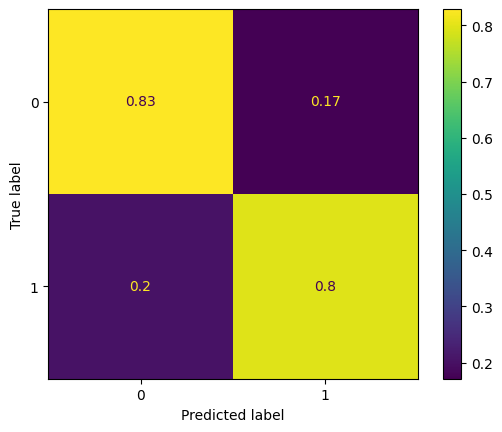

In [52]:
# Calculate precision, recall, and F1 scoreb
report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Evaluate using precision/pnl at k

In [67]:
y_pred_proba_lt_exit = [x[1] for x in xgb_lt_exit.predict_proba(scaled_X_test)]
y_pred_proba_st_entry = [x[1] for x in xgb_st_entry.predict_proba(scaled_X_test)]
test_data_enriched = df[['Date','Ticker_P1', 'Ticker_P2', 'pnls', 'both_legs_profited']].loc[y_test.index]

In [71]:
test_data_enriched['predicted_proba_st_entry'] = y_pred_proba_st_entry
test_data_enriched['predicted_proba_lt_exit'] = y_pred_proba_lt_exit
test_data_enriched['predicted_score_combined'] =  \
(test_data_enriched['predicted_proba_st_entry'] + test_data_enriched['predicted_proba_lt_exit'])/2

## Precision at k

binary label - both logs profited

In [96]:
# def evaluate(model, k):
#     """
#     model: str, one of predicted_proba_st_entry, predicted_proba_lt_exit, predicted_score_combined
#     """
#     agg_y_test = test_data_enriched.groupby('Date').apply(lambda x: x.nlargest(k, model)).reset_index(drop=True)
#     precision_at_k = agg_y_test.groupby('Date').max('both_legs_profited').reset_index(drop=True).both_legs_profited.mean()
#     pnl_at_k = agg_y_test.groupby('Date').mean('pnls').reset_index(drop=True).pnls.mean()

#     return precision_at_k, pnl_at_k

model_names = ['predicted_proba_st_entry', 'predicted_proba_lt_exit', 'predicted_score_combined']
all_ks = [1, 3, 5]

models_used = []
top_k = []
pct_pair_profited = []
avg_pnls = []

for model in model_names:
    for k in all_ks:
        agg_y_test = test_data_enriched.groupby('Date').apply(lambda x: x.nlargest(k, model)).reset_index(drop=True)
        precision_at_k = agg_y_test.groupby('Date').max('both_legs_profited').reset_index(drop=True).both_legs_profited.mean()
        pnl_at_k = agg_y_test.groupby('Date').mean('pnls').reset_index(drop=True).pnls.mean()
        models_used.append(model)
        top_k.append(k)
        pct_pair_profited.append(precision_at_k)  
        avg_pnls.append(pnl_at_k)

In [103]:
summary_tb = pd.DataFrame()
summary_tb['models_used'] = models_used
summary_tb['top_k'] = top_k
summary_tb['pct_pair_both_leg_profited_at_k (%)'] = np.array(pct_pair_profited)*100
summary_tb['avg_pnls_at_k (%)'] = avg_pnls
summary_tb

,models_used,top_k,pct_pair_both_leg_profited_at_k (%),avg_pnls_at_k (%)
0,predicted_proba_st_entry,1,28.125,0.820
1,predicted_proba_st_entry,3,54.688,0.406
2,predicted_proba_st_entry,5,67.188,0.205
3,predicted_proba_lt_exit,1,10.938,-0.102
4,predicted_proba_lt_exit,3,31.250,0.211
5,predicted_proba_lt_exit,5,45.312,0.119
6,predicted_score_combined,1,20.312,-1.974
7,predicted_score_combined,3,46.875,-0.821
8,predicted_score_combined,5,60.938,-0.589
